In [1]:
!pip install tensorflow scikit-image lpips torch numpy matplotlib pandas

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import lpips
import torch
import pandas as pd

In [3]:


# Set matplotlib to inline for Jupyter (comment out if running as script)
# %matplotlib inline

# Function to load and preprocess images
def load_image(image_path):
    max_dim = 512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

# Function to display images
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = np.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

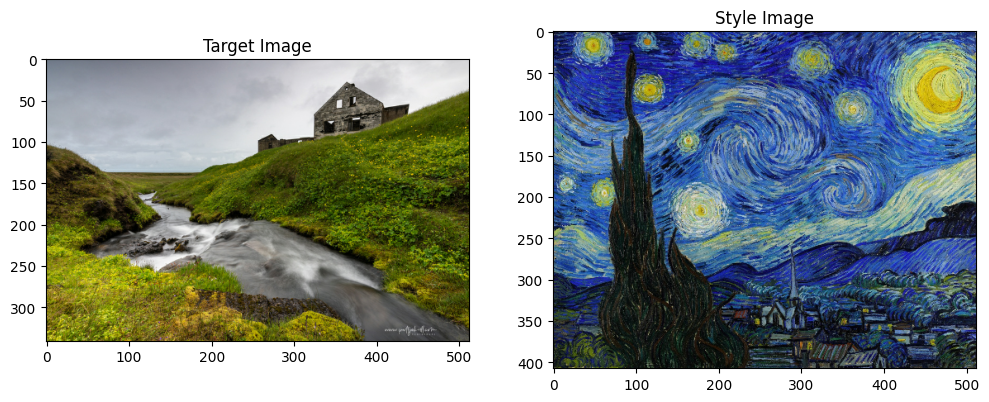

Content image shape: (1, 341, 512, 3)
Style image shape: (1, 408, 512, 3)


In [4]:


# Load content and style images
content_img = load_image('./test.jpg')
style_img = load_image('./starry.jpg')

# Visualize input images
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
imshow(content_img, 'Target Image')
plt.subplot(1, 2, 2)
imshow(style_img, 'Style Image')
plt.show()

print("Content image shape:", content_img.shape)
print("Style image shape:", style_img.shape)

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, None,      │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, None,      │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, None,      │          0 │ normalization_3[… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

d:\miniconda\envs\aashuenv\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_952']
Received: inputs=Tensor(shape=(1, 408, 512, 3))
  warnings.warn(msg)
d:\miniconda\envs\aashuenv\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1190']
Received: inputs=Tensor(shape=(1, 408, 512, 3))
  warnings.warn(msg)
d:\miniconda\envs\aashuenv\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1190']
Received: inputs=Tensor(shape=(1, 341, 512, 3))
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: d:\miniconda\envs\aashuenv\lib\site-packages\lpips\weights\v0.1\alex.pth
0


C:\Users\Nawaz sheriff\AppData\Local\Temp\ipykernel_9576\622928300.py:131: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  content_img_torch = torch.from_numpy(content_img_np.transpose(2, 0, 1)).unsqueeze(0) * 2 - 1


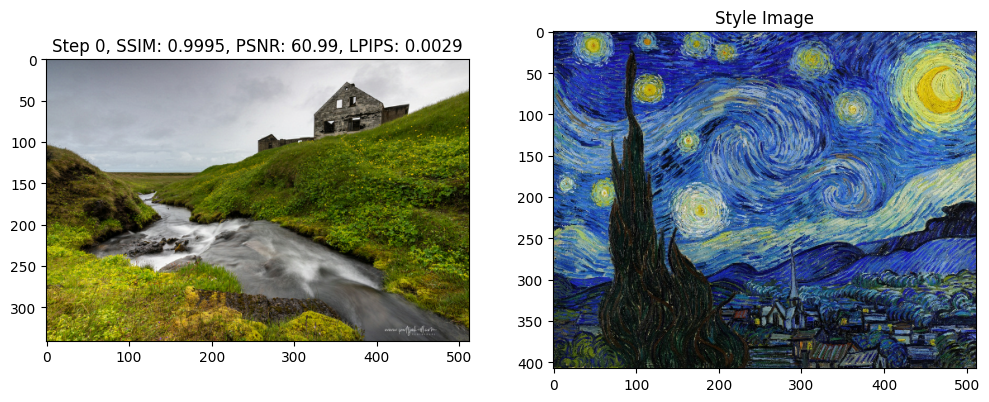

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


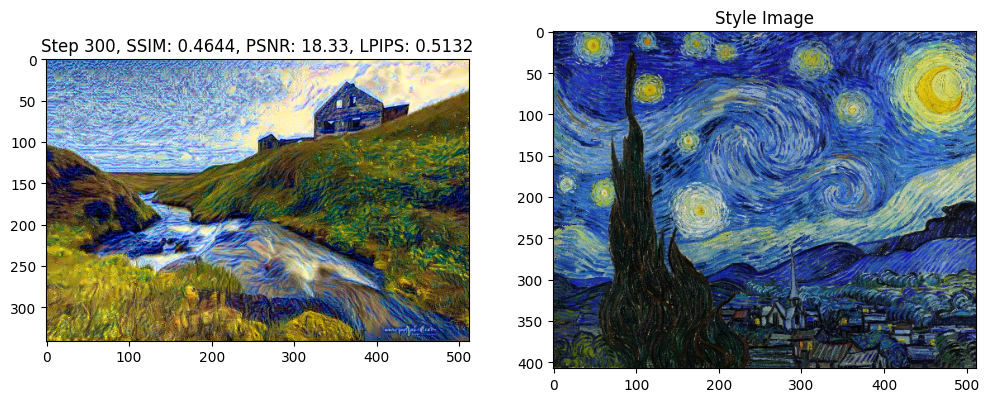

301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550


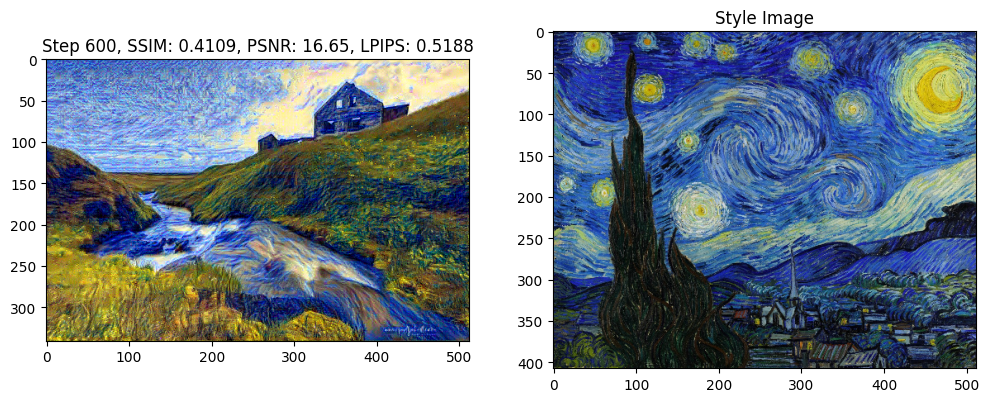

601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850


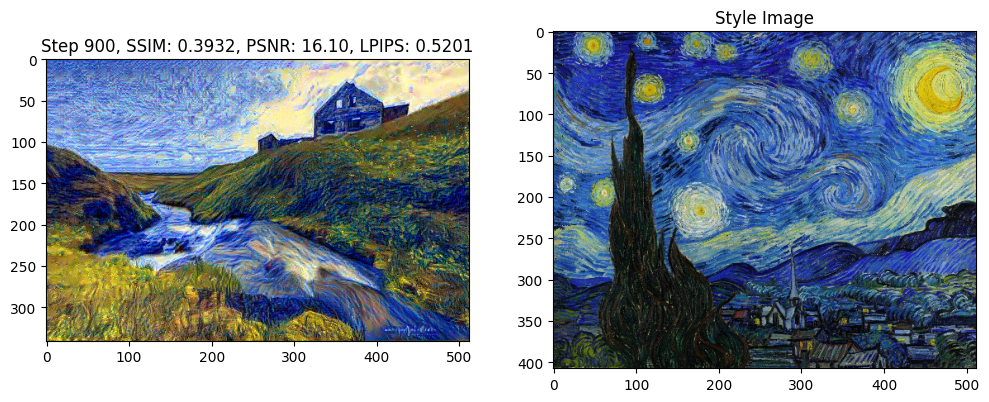

901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120

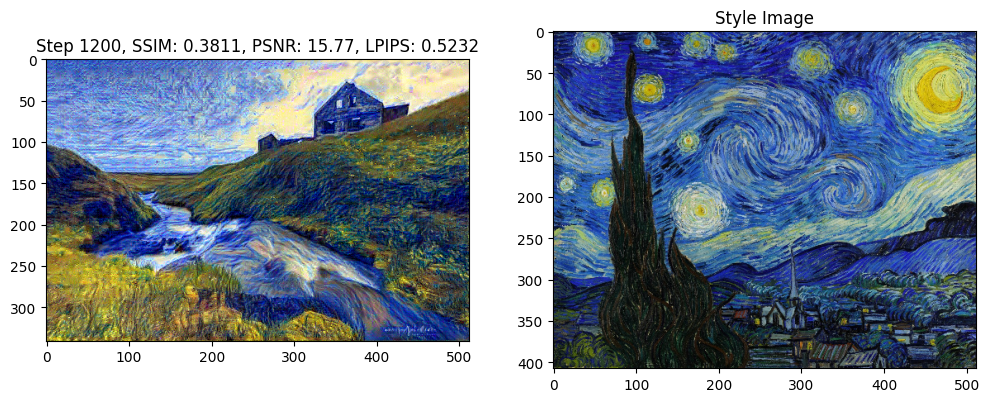

1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400


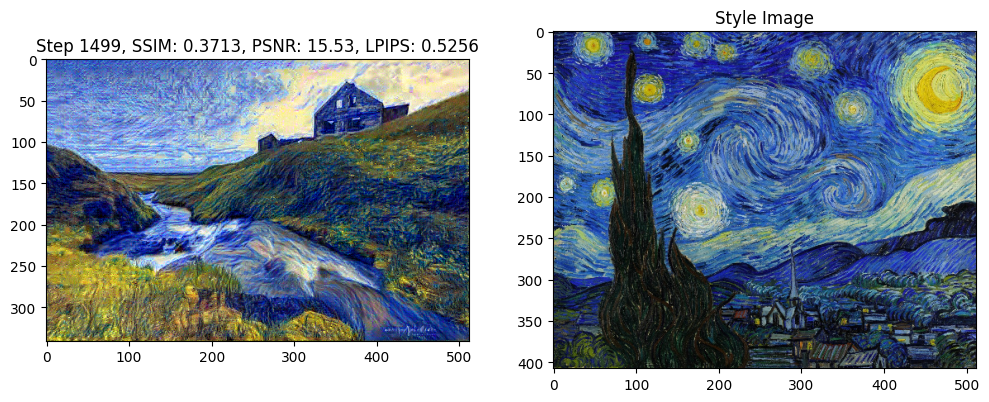

(<tf.Tensor: shape=(), dtype=float32, numpy=62.268070220947266>,
 <tf.Tensor: shape=(), dtype=float32, numpy=31.679615020751953>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.588455200195312>)

In [6]:
# Define EfficientNet-B0 model
x = tf.keras.applications.efficientnet.preprocess_input(content_img * 255)
x = tf.image.resize(x, (224, 224))  # EfficientNet-B0 expects 224x224
efficientnet_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
efficientnet_model.trainable = False
efficientnet_model.summary()

# Define content and style layers for EfficientNet-B0
content_layers = ['block5a_project_bn']  # Mid-level layer for content
style_layers = [
    'block1a_project_bn',  # Early layer for low-level features
    'block2a_project_bn',  # Intermediate layers for textures
    'block3a_project_bn',
    'block4a_project_bn',
    'block5a_project_bn'   # Deeper layer for complex patterns
]

# Build model to extract features from specified layers
def my_model(layer_names):
    efficientnet_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
    efficientnet_model.trainable = False
    outputs = [efficientnet_model.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([efficientnet_model.input], outputs)
    return model

# Extract style features
style_extractor = my_model(style_layers)
style_outputs = style_extractor(style_img * 255)

# Compute Gram matrix
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

# Define the NST model class
class entire_model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(entire_model, self).__init__()
        self.efficientnet = my_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.efficientnet.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.efficientnet.preprocess_input(inputs)
        outputs = self.efficientnet(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(layer) for layer in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

# Initialize NST model and extract targets
extractor = entire_model(style_layers, content_layers)
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

# Define weights
style_weight = 40
content_weight = 10
style_weights = {
    'block1a_project_bn': 0.2,
    'block2a_project_bn': 0.19,
    'block3a_project_bn': 0.24,
    'block4a_project_bn': 0.11,
    'block5a_project_bn': 0.26
}

# Loss function
def total_cost(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([style_weights[name] * tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss, style_loss, content_loss

# Initialize generated image
generate_image = tf.Variable(content_img)

# Clip pixel values
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Initialize LPIPS
loss_fn = lpips.LPIPS(net='alex')

# Training loop with metric recording
num_iterations = 1500
metrics = {
    'iteration': [],
    'style_loss': [],
    'content_loss': [],
    'total_loss': [],
    'inference_time': [],
    'ssim': [],
    'psnr': [],
    'lpips': []
}

for i in range(num_iterations):
    print(i)
    start_time = time.time()
    loss, style_loss, content_loss = train_step(generate_image)
    inference_time = (time.time() - start_time) * 1000  # Convert to ms

    if i % 300 == 0 or i == num_iterations - 1:
        content_img_np = np.squeeze(content_img, axis=0)
        generated_img_np = np.squeeze(generate_image.read_value(), axis=0)
        
        # Compute SSIM (Fixed: Added data_range=1.0)
        ssim_score = ssim(content_img_np, generated_img_np, multichannel=True, channel_axis=2, data_range=1.0)
        
        # Compute PSNR
        psnr_score = psnr(content_img_np, generated_img_np, data_range=1.0)
        
        # Compute LPIPS
        content_img_torch = torch.from_numpy(content_img_np.transpose(2, 0, 1)).unsqueeze(0) * 2 - 1
        generated_img_torch = torch.from_numpy(generated_img_np.transpose(2, 0, 1)).unsqueeze(0) * 2 - 1
        lpips_score = loss_fn(content_img_torch, generated_img_torch).item()

        # Record metrics
        metrics['iteration'].append(i)
        metrics['style_loss'].append(style_loss.numpy())
        metrics['content_loss'].append(content_loss.numpy())
        metrics['total_loss'].append(loss.numpy())
        metrics['inference_time'].append(inference_time)
        metrics['ssim'].append(ssim_score)
        metrics['psnr'].append(psnr_score)
        metrics['lpips'].append(lpips_score)

        # Visualize progress
        plt.figure(figsize=(12, 12))
        plt.subplot(1, 2, 1)
        imshow(generated_img_np, f'Step {i}, SSIM: {ssim_score:.4f}, PSNR: {psnr_score:.2f}, LPIPS: {lpips_score:.4f}')
        plt.subplot(1, 2, 2)
        imshow(style_img, 'Style Image')
        plt.show()

# Final training step
train_step(generate_image)

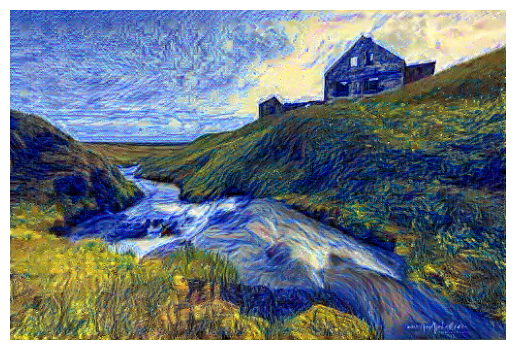

Metrics saved to EfficientNetB0_metrics.csv


In [7]:
# Save final image
plt.imshow(np.squeeze(generate_image.read_value(), axis=0))
plt.axis('off')
plt.savefig('EfficientNetB0_new_image.png', bbox_inches='tight')
plt.show()

# Save metrics to CSV
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('EfficientNetB0_metrics.csv', index=False)
print("Metrics saved to EfficientNetB0_metrics.csv")

Saved as ResNet50_completed.csv
